# Stochastic Gradient Descent (SGD)

## Load Dataset from sklearn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [4]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


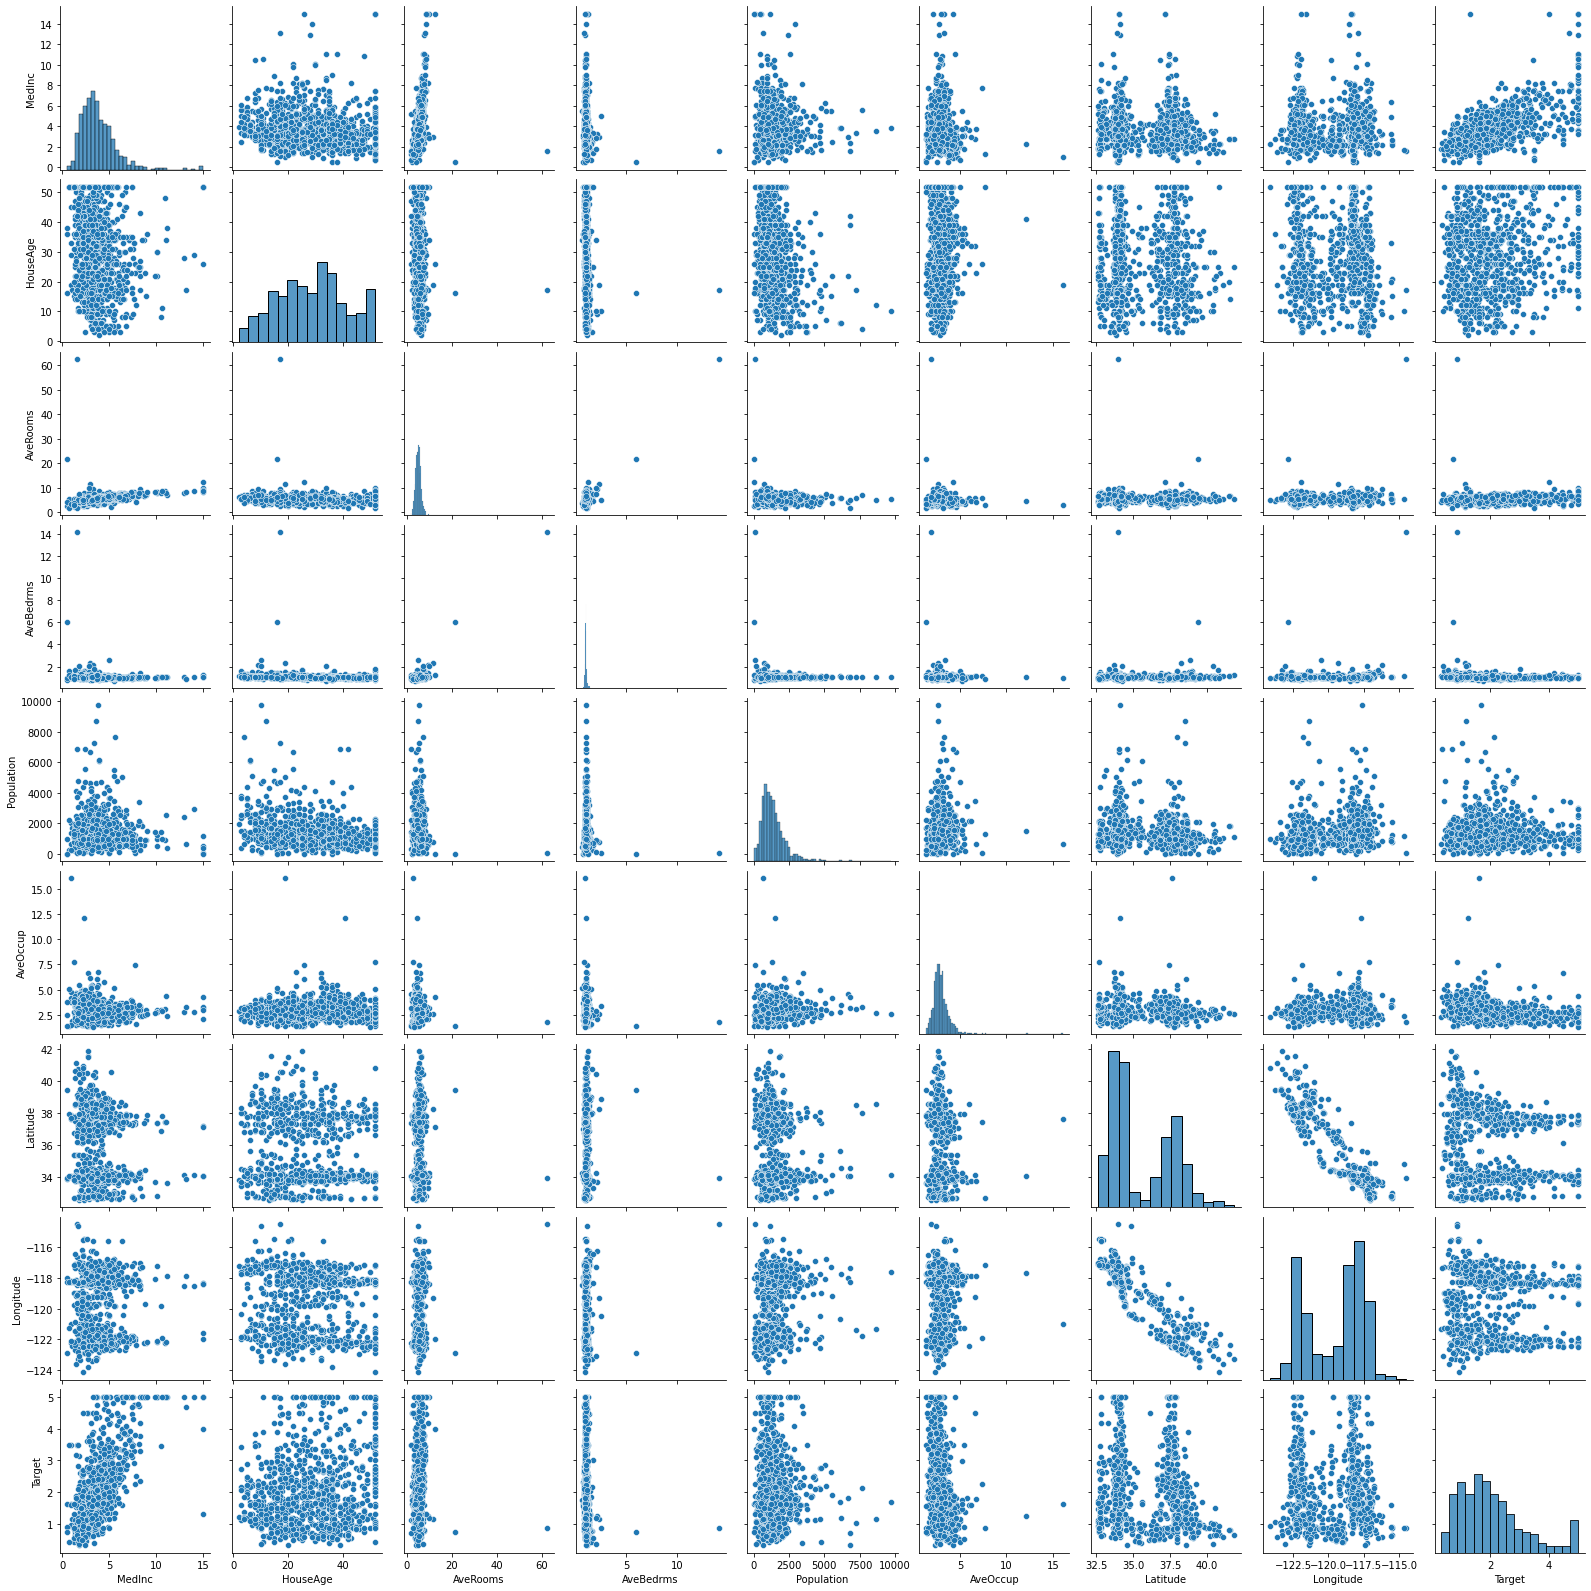

In [5]:
sns.pairplot(df.sample(1000))
plt.show()

In [6]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1]) # 평균, 표준편차 학습
df.values[:, :-1] = scaler.transform(df.values[:, :-1]) # 학습한 평균, 표준편차 적용

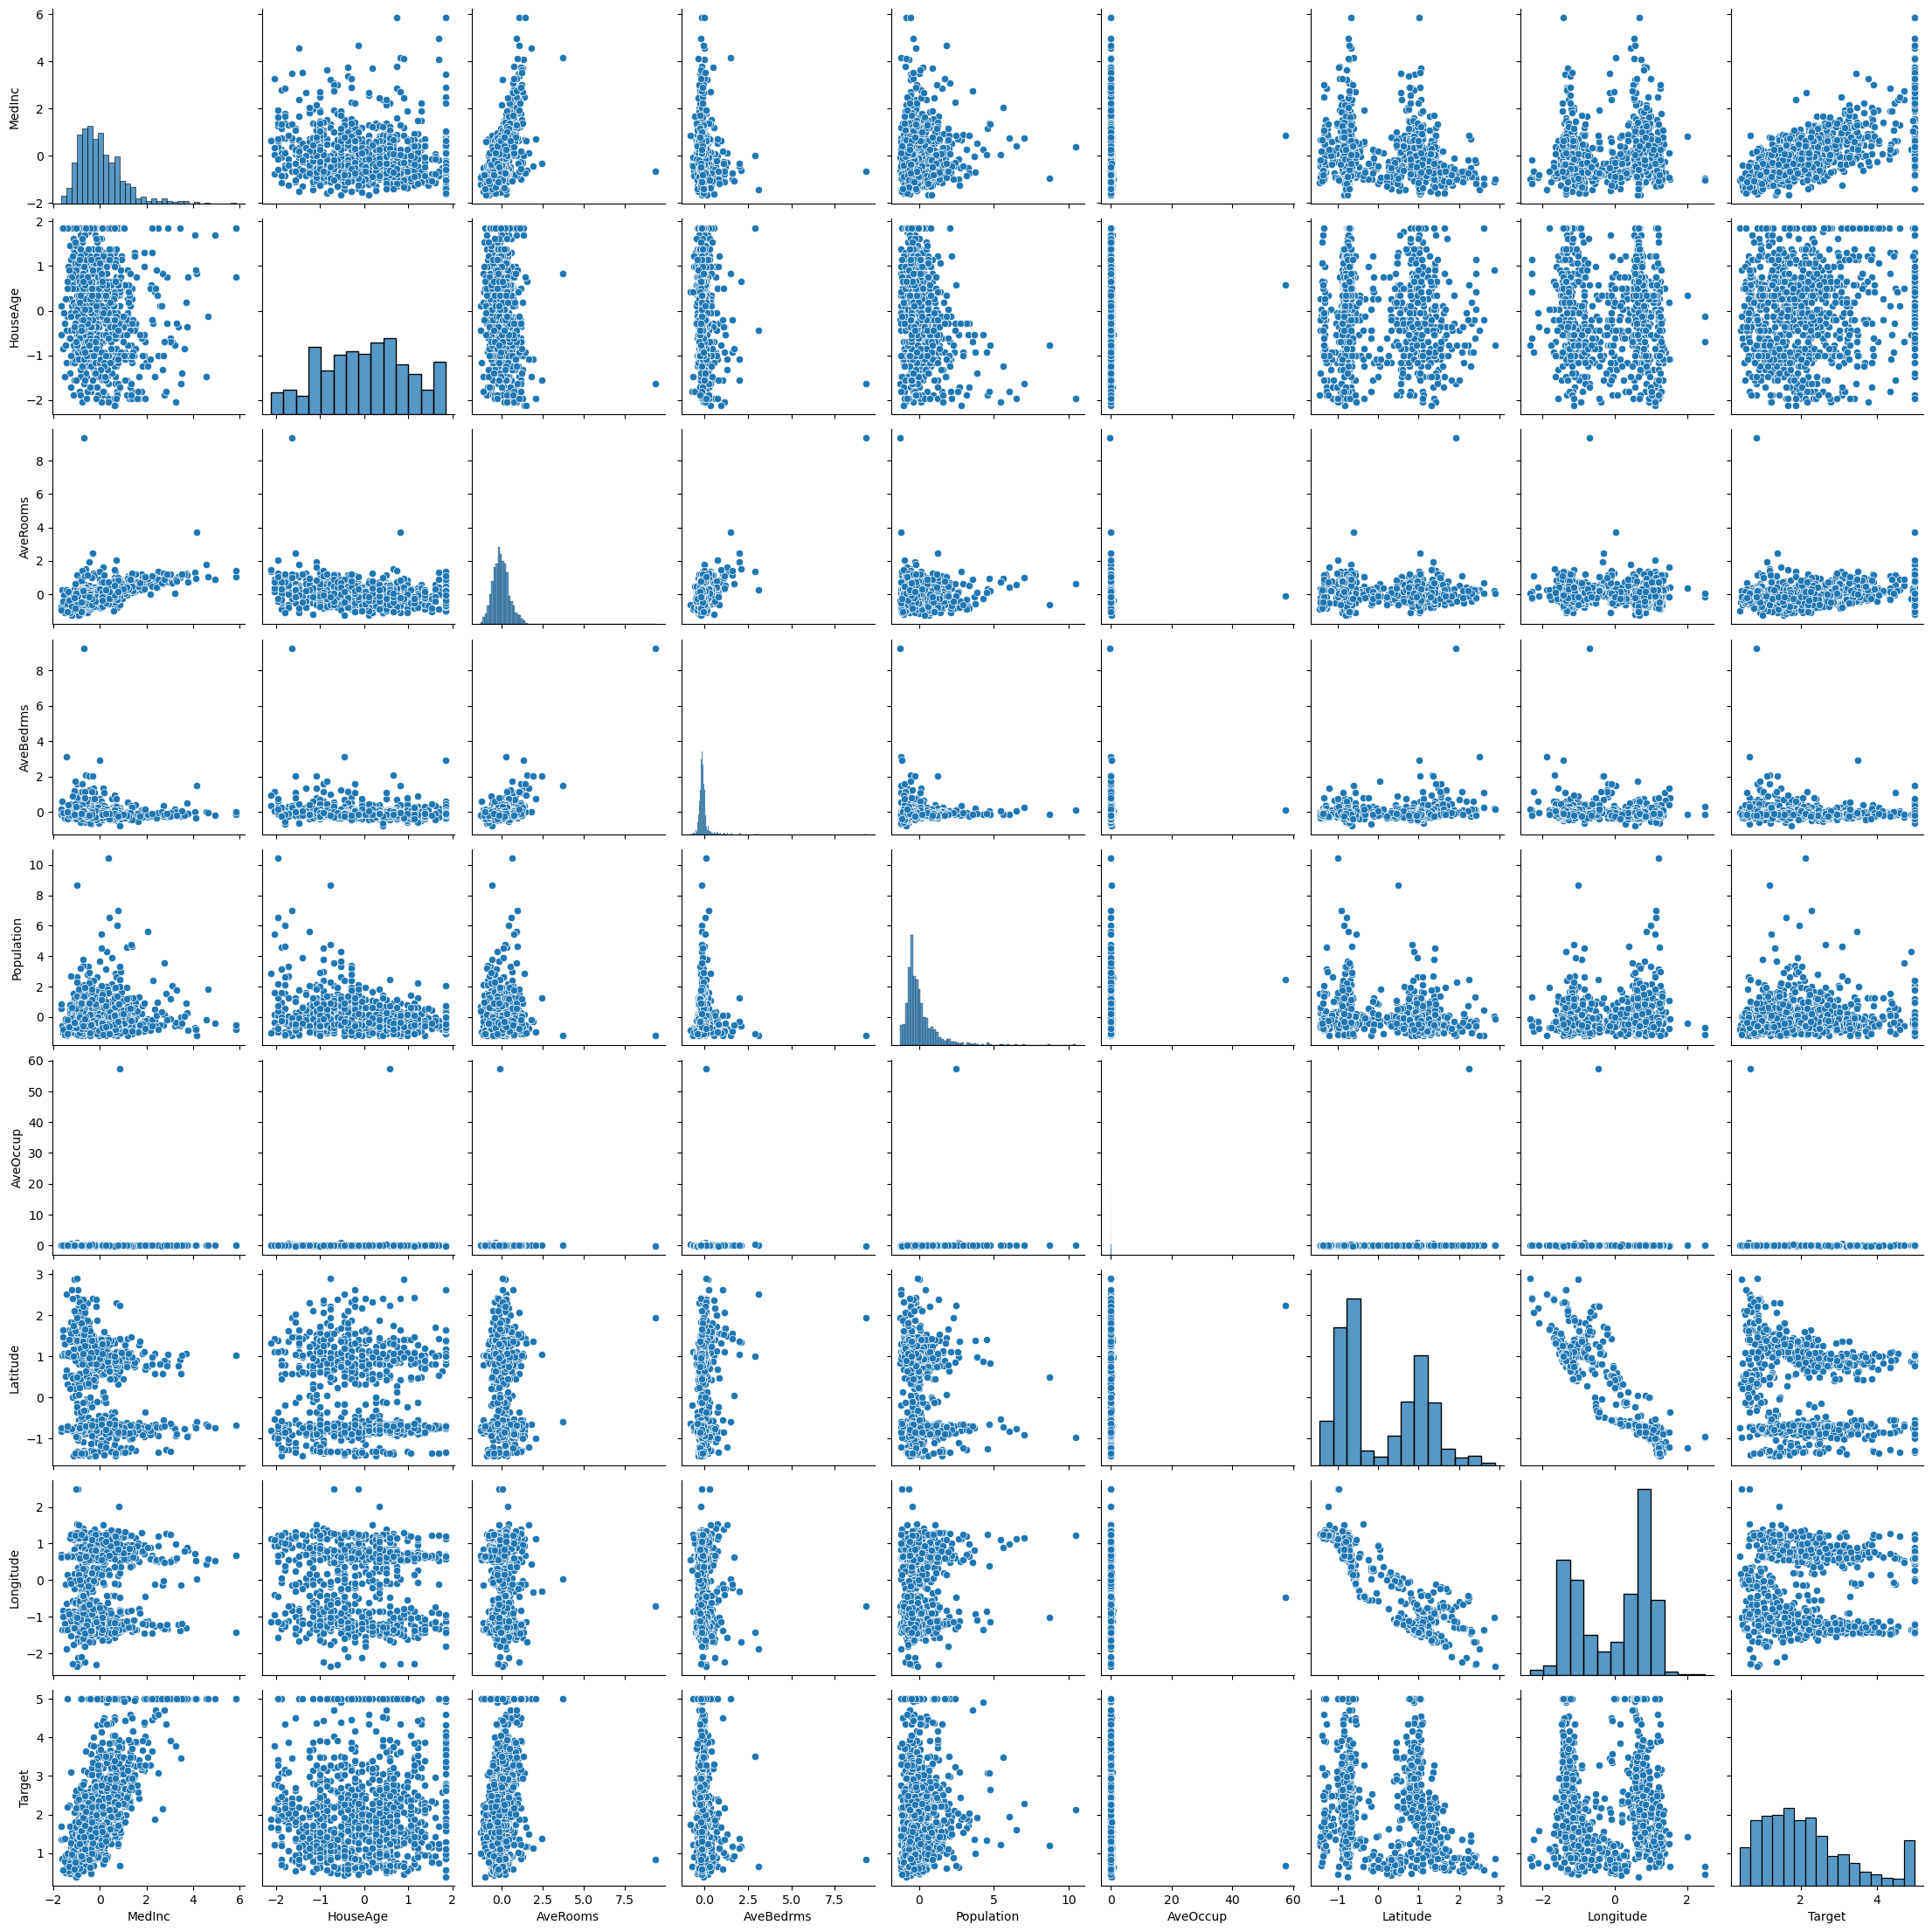

In [7]:
sns.pairplot(df.sample(1000))
plt.show()

## Train Model with PyTorch

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
data = torch.from_numpy(df.values).float()

data.shape

torch.Size([20640, 9])

In [10]:
x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [11]:
n_epochs = 4000
batch_size = 256
print_interval = 200
learning_rate = 1e-2

## Build Models

In [12]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [13]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
# |x| = (total_size, input_dim)
# |y| = (total_size, output_dim)

for i in range(n_epochs):
    # Shuffle the index to feed-forward.
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices) # 같은 random index를 사용해야함!
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    y_hat = []
    total_loss = 0
    
    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step() # 한걸음 앞으로
        
        total_loss += float(loss) # This is very important to prevent memory leak.
        y_hat += [y_hat_i]

    total_loss = total_loss / len(x_)
    if (i + 1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i + 1, total_loss))
    
y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)
# |y_hat| = (total_size, output_dim)
# |y| = (total_size, output_dim)

Epoch 200: loss=3.2761e-01
Epoch 400: loss=3.0889e-01
Epoch 600: loss=3.0031e-01
Epoch 800: loss=2.9159e-01
Epoch 1000: loss=2.8963e-01
Epoch 1200: loss=2.8835e-01
Epoch 1400: loss=2.8675e-01
Epoch 1600: loss=2.8668e-01
Epoch 1800: loss=2.8625e-01
Epoch 2000: loss=2.8652e-01
Epoch 2200: loss=2.8536e-01
Epoch 2400: loss=2.8506e-01
Epoch 2600: loss=2.8569e-01
Epoch 2800: loss=2.8512e-01
Epoch 3000: loss=2.8454e-01
Epoch 3200: loss=2.8301e-01
Epoch 3400: loss=2.8329e-01
Epoch 3600: loss=2.8321e-01
Epoch 3800: loss=2.8382e-01
Epoch 4000: loss=2.8326e-01


## Let's see the result!

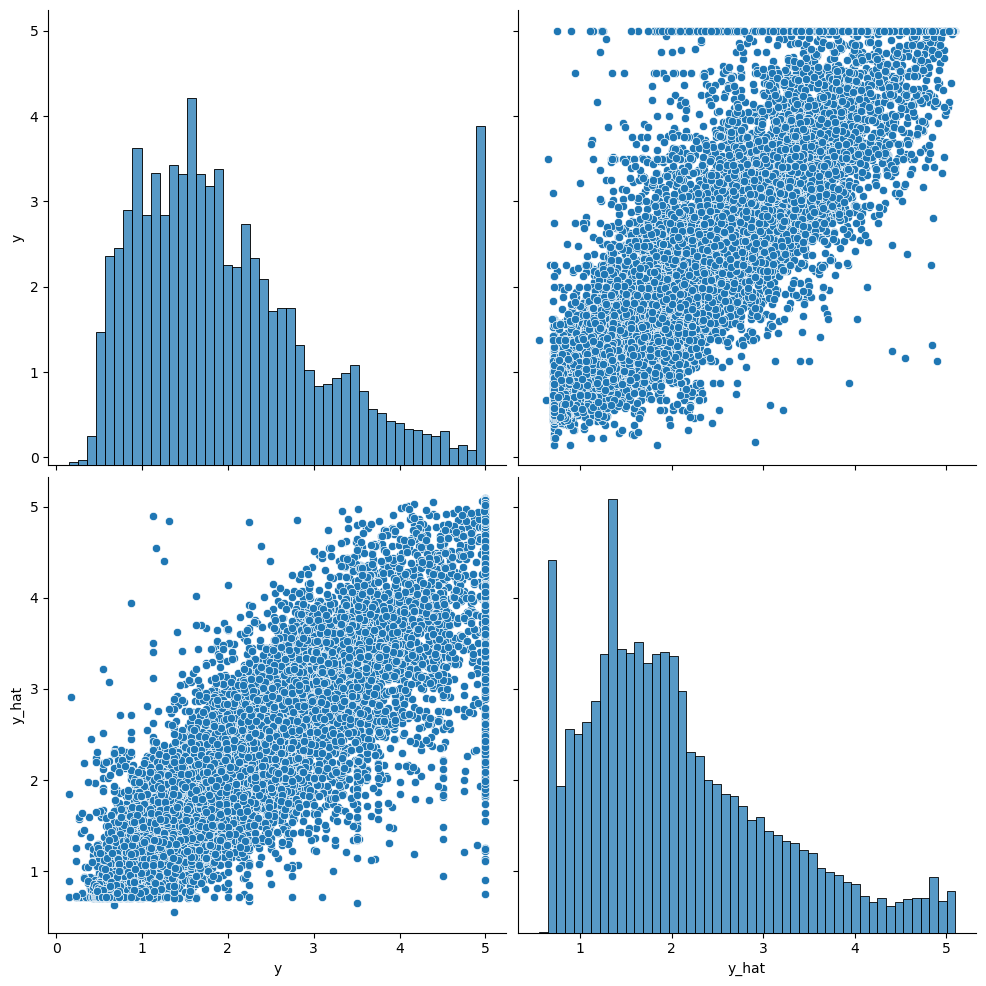

In [15]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()